In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import logomaker

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 9,935
training + validation N: 40,583


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,training,0,1,0,0,0,0,0,0,0,0,AAAAAAAGTGAGTTAGCCAACTAATTAGGCACCGTACGCTTTATAG...
1,training,0,0,0,0,0,0,0,0,0,1,AAAAAATGAGAGTTAGTTCACTCATTCGGCACCACAGGCTTTACAA...
2,training,0,0,0,0,0,0,0,0,0,1,AAAAAATGGGTGTTAGCTCTATCATTAGGCACCCCCGGCTTTACAC...
3,training,0,1,0,0,0,0,0,0,0,0,AAAAAATGTCAGTTAGCTGACTCATTAGGCACCCCTGGCTTTACGT...
4,validation,0,0,0,0,0,0,1,0,0,0,AAAAAATGTGAGAAAGCTCACTCCTTTGGCACCGCAGGCTTTACAC...
5,validation,0,0,0,0,0,0,0,0,0,1,AAAAAATGTGAGATAGGTCACTCCTAAGGCACCCCAGGCTTTACAA...
6,training,0,0,1,0,0,0,0,0,0,0,AAAAAATGTGAGGTAGCTCAGTCCACAGGCACCCCAGCCTTTAAAC...
7,training,0,0,0,0,0,0,0,1,0,0,AAAAAATGTGAGTTAGCTAACTCATTAGGTACCCCAGGATTTACAC...
8,training,1,0,0,0,0,0,0,0,0,0,AAAAAATGTGAGTTAGCTCACTCTTTAGGAATCCCAGGCTTTACAC...
9,validation,0,1,0,0,0,0,0,0,0,0,AAAAAATGTGAGTTAGTACATTCGTTAGGCACCCCAGTCTTTACCC...


In [3]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=75, Y=10


In [4]:
# Get sequence length
L = len(data_df['x'][0])

# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet='dna',
                     gpmap_type='additive',
                     mpa_hidden_nodes=100)

# Set training data
model.set_data(x=data_df['x'],
               y=data_df[y_cols],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)

# Save model
model.save('sortseq_full-wt_mpa_additive')

N = 40,583 observations set as training data.
Using 24.8% for validation.
Data shuffled.
Time to set data: 0.326 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has 30516 rows and 300 columns
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      300

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  9.219e+02  1.045e+06   1.0e+00  1.2e+00
     1  6.59363e-02  4.955e+02  1.581e+04   5.4e-01  2.4e-02  1.3e+03  1.0e+00
     2 -1.35159e-02  4.275e+02  4.154e+03   4.6e-01  7.2e-03  1.3e+03  2.1e+01
     3 -5.97624e-02  4.172e+02  2.169e+03   4.5e-01  3.9e-03  1.3e+03  3.1e+01
     4 -2.95735e-02  4.133e+02  8.305e+02   4.5e-01  1.5e-03  1.3e+03  3.1e+01
     5 -3.03518e-02  4.132e+02  7.221e+02   4.5e-01  1.3e-03  1.3e+03  2.9e+01
     6 -3.21013e-02  4.129e+02  3.675e+02   4.5e-01  4.8e-04  1.9e+03  2.9e+01
     7 -3.76395e-02  4.128e+02  1.612e+02

In [5]:
# Load model
model = mavenn.load('sortseq_full-wt_mpa_additive')

Model loaded from these files:
	sortseq_full-wt_mpa_additive.pickle
	sortseq_full-wt_mpa_additive.weights.h5


On test data:
I_var_test: 0.640 +- 0.011 bits
I_pred_test: 0.653 +- 0.011 bits


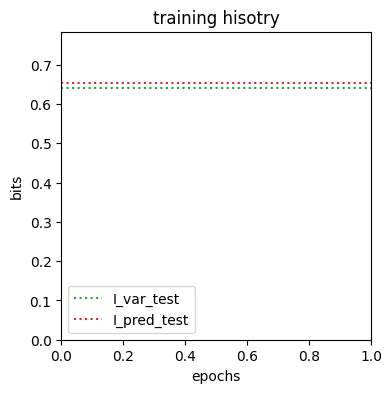

In [6]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

#I_var_hist = model.history['I_var']
#val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
#ax.plot(I_var_hist, label='I_var_train')
#ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

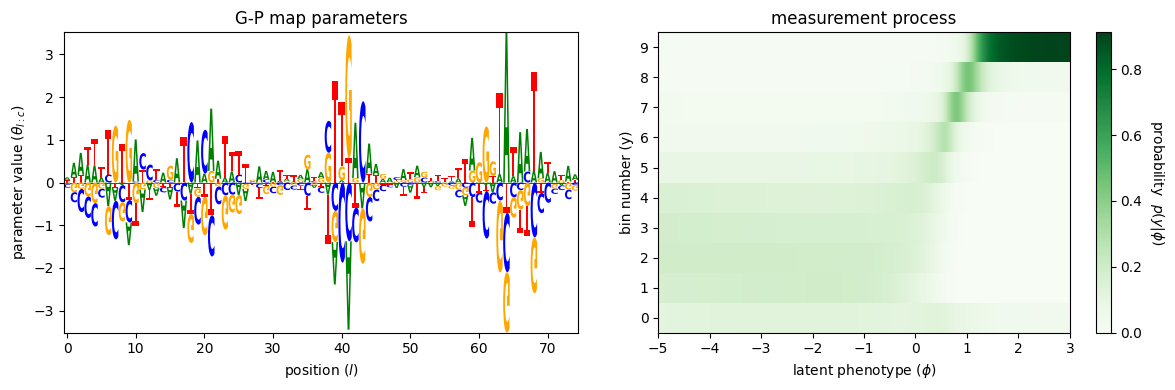

In [7]:
# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel(r'bin number (y)')
ax.set_xlabel(r'latent phenotype ($\phi$)')
ax.set_title(r'measurement process')
cb = plt.colorbar(im)
cb.set_label(r'probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('sortseq_g-p_map_mpa_visualization.png')
plt.show()

In [8]:
# Test simulate_data; simulate both training and test sets
sim_df = model.simulate_dataset(template_df=data_df)
sim_test_df = model.simulate_dataset(template_df=test_df)
sim_test_df.head()

,set,phi,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,test,0.692768,1,0,0,0,0,0,0,0,0,0,AAAAAATCTGAGTTAGCTTACTCATTAGGCACCCCAGGCTTGACAC...
1,test,0.688305,0,0,0,0,0,0,0,1,0,0,AAAAAATCTGAGTTTGCTCACTCTATCGGCACCCCAGTCTTTACAC...
2,test,-1.087948,0,0,1,0,0,0,0,0,0,0,AAAAAATGTAAGTTAGCTCACTCATTCGGCTCCCCAGGCTTTACAC...
3,test,-3.285155,0,1,0,0,0,0,0,0,0,0,AAAAAATGTGAGTCAGCTAACTCATTAGGCGGCCCAGGCTCTAGGC...
4,test,0.923309,0,0,0,0,0,0,0,0,0,1,AAAAAATGTGGGTTAGCTCATGCTTTAGGCTCCCTAGTCTTTACAC...


In [9]:
# Define model
sim_model = mavenn.Model(regression_type='MPA',
                        L=L,
                        Y=Y,
                        alphabet='dna',
                        gpmap_type='additive',
                        mpa_hidden_nodes=100)

# Where is ct_n?
sim_model.set_data(x=sim_df['x'],
                   y=sim_df[y_cols])

# Fit model to data
sim_model.fit(learning_rate=.005,
              epochs=1000,
              batch_size=500,
              early_stopping=True,
              early_stopping_patience=10,
              linear_initialization=True)

N = 40,583 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.357 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has 32453 rows and 300 columns
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      300

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  9.609e+02  1.125e+06   1.0e+00  1.2e+00
     1  6.66992e-02  5.143e+02  1.736e+04   5.4e-01  2.4e-02  1.4e+03  1.0e+00
     2 -5.55034e-02  4.404e+02  4.391e+03   4.6e-01  7.2e-03  1.4e+03  2.1e+01
     3 -7.30180e-02  4.305e+02  2.242e+03   4.5e-01  3.7e-03  1.4e+03  3.0e+01
     4 -5.16148e-02  4.267e+02  8.973e+02   4.4e-01  1.5e-03  1.4e+03  3.2e+01
     5 -5.16162e-02  4.267e+02  8.944e+02   4.4e-01  1.5e-03  1.4e+03  2.9e+01
     6 -5.25754e-02  4.263e+02  4.014e+02   4.4e-01  4.8e-04  2.0e+03  2.9e+01
     7 -5.87279e-02  4.261e+02  1.640e+02

On test data:
I_intr_like: 0.659 +- 0.011 bits
I_intr_pred: 0.667 +- 0.010 bits
I_var_test: 0.647 +- 0.011 bits
I_pred_test: 0.639 +- 0.014 bits


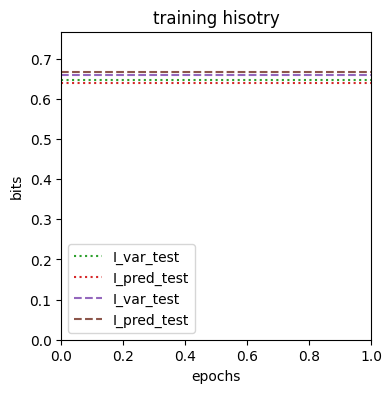

In [10]:
# Show training history
print('On test data:')
x_test = sim_test_df['x'].values
y_test = sim_test_df[y_cols].values

# Compute the intrinsic information using the true model
I_intr_like, dI_intr_like =  model.I_variational(x=x_test, y=y_test)
print(f'I_intr_like: {I_intr_like:.3f} +- {dI_intr_like:.3f} bits') 

I_intr_pred, dI_intr_pred =  model.I_predictive(x=x_test, y=y_test)
print(f'I_intr_pred: {I_intr_pred:.3f} +- {dI_intr_pred:.3f} bits') 

# Compute likelihood information
I_var, dI_var =  sim_model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = sim_model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

#I_var_hist = sim_model.history['I_var']
#val_I_var_hist = sim_model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
#ax.plot(I_var_hist, label='I_var_train')
#ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.axhline(I_intr_like, color='C4', linestyle='--', label='I_var_test')
ax.axhline(I_intr_pred, color='C5', linestyle='--', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);